### Common Imports

In [1]:
import math
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

Define a global value for scikit-learn's 'n_jobs' parameter that depends on the current user:

In [2]:
n_jobs = -1 if os.getlogin() == 'brett' else -1

---
## Task 1 - Identify Features

- **Assemble a dataset consisting of features and target:**

In [3]:
# Read in all vehicle data
vehicle_data = pd.read_csv('./vehicles.csv')

In [4]:
# Print basic info
data_shape = vehicle_data.shape
print(f'Data has {data_shape[0]:,} rows and {data_shape[1]} columns')

Data has 509,577 rows and 25 columns


In [5]:
# Separate data into raw features and target
target_col = 'price'
raw_features = vehicle_data.drop(columns=target_col)
raw_target = vehicle_data.price

- **What features are relevant for the prediction task?**

Certainly features that are entirely **empty** cannot be informative:

In [6]:
empty_features = raw_features.columns[raw_features.isna().all()].to_list()
print('Entirely empty features:', empty_features)

Entirely empty features: ['county']


Based purely on the **column descriptions**, in their current form some features will likely be irrelevant to predict price:
- 'url', 'vin', and 'image_url' are strings that should be unique per vehicle / listing
- One-hot encoding these strings would roughly generate a unique feature per row, which would not be useful for predition.

**Note**: we may end up extracting new features from some of these dropped columns in Task 3.

In [7]:
irrelevant_features = ['url', 'vin', 'image_url']

To get a sense of how relevant the remaining features may be to predict price, we can **visualize their relationship to the target value**:

In [8]:
relevant_features = raw_features.columns.difference(empty_features+irrelevant_features, sort=False)
relevant_types = raw_features.dtypes[relevant_features]

Our visualizations won't be very effective if outlier prices ruin the scaling.  Let's look at the distribution of prices in the data:

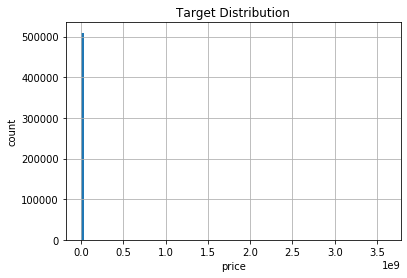

In [9]:
raw_target.hist(bins=100)
plt.title('Target Distribution')
plt.xlabel('price')
plt.ylabel('count');

Looking at the scale of the x-axis, there are clearly some **outlier prices** that will disrupt the scaling of our visualizations.  To prevent this, we'll limit our visualizations to prices greater than 0 and within the 99.9th percentile of the distribution:

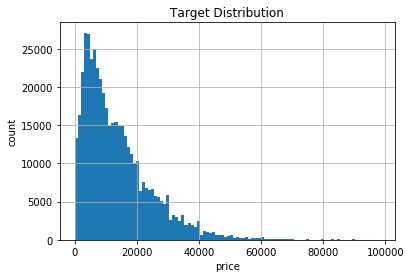

In [10]:
valid_price_rows = (raw_target > 0) & (raw_target < raw_target.quantile(.999))

# Replot the histogram
raw_target[valid_price_rows].hist(bins=100)
plt.title('Target Distribution')
plt.xlabel('price')
plt.ylabel('count');

That looks like a much smoother distribution of used vehicle prices.  Now we can visualize the features' relationship to the target:

##### Continuous Features vs. Target

In [11]:
continuous_features = relevant_features[relevant_types != 'object']

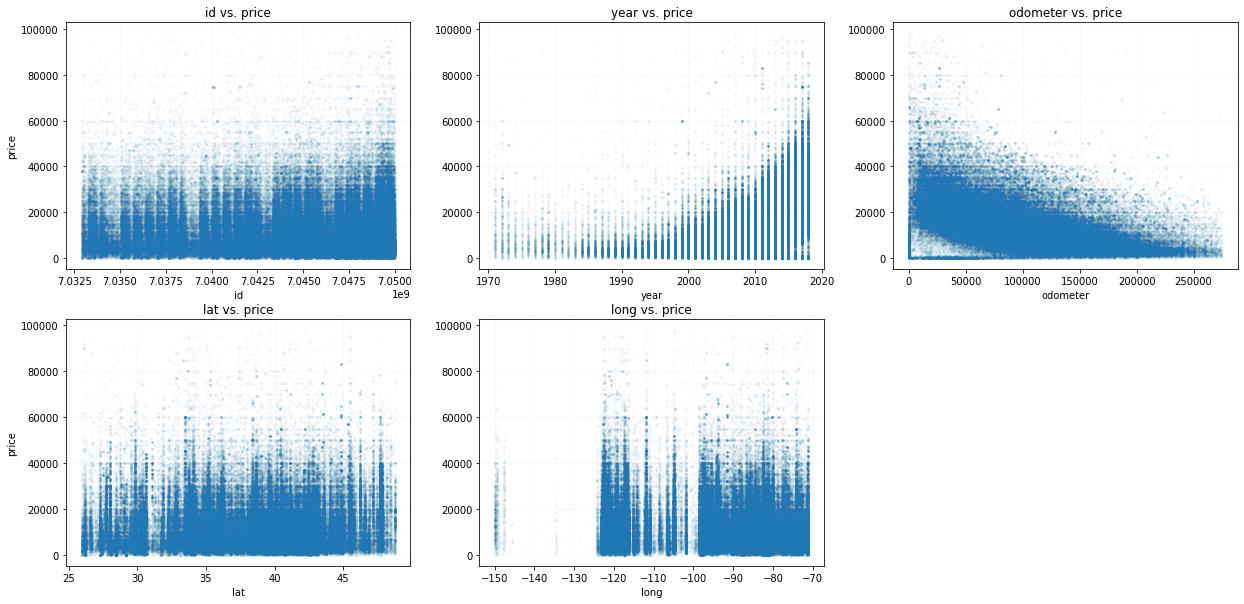

In [12]:
# Figure out an appropriate number of rows and columns
num_plots = len(continuous_features)
plot_cols = 3
plot_rows = math.ceil(num_plots / plot_cols)

# For each continuous feature...
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)
for i, feature in enumerate(continuous_features):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
    
    # Decide which rows to plot for this feature
    # To avoid outliers distorting the scale of the x-axis, we'll ignore data below the 1st percentile
    # or above the 99th percentile.
    feature_col = raw_features[feature]
    feature_rows = (feature_col > feature_col.quantile(.01)) & (feature_col < feature_col.quantile(.99))
    rows_to_plot = valid_price_rows & feature_rows
    
    # Create a scatter plot for this feature vs. target
    ax.scatter(feature_col[rows_to_plot], raw_target[rows_to_plot], s=3, alpha=0.02)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' vs. price')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('price')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_plots
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

From these plots, we conclude the following:
- both 'year' and 'odometer' have strong correlations with 'price' (although in opposite directions)
- 'id' may have a weak positive correlation with 'price' (although we may drop it for other reasons - see below)
- 'lat' and 'long' by themselves do not appear to have a specific relationship to 'price'.  These may require more advanced feature engineering to extract predictive information.

In [13]:
uninformative_features = ['lat', 'long']

##### Ordinal Features vs. Target

The remaining features are **discrete** (non-continuous):

In [14]:
relevant_features.difference(continuous_features, sort=False)

Index(['region', 'region_url', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'description', 'state'],
      dtype='object')

The provided descriptions of these features suggest several of them (condition, cylinders, and size) are **ordinal** in nature (discrete and ordered): 

In [15]:
ordinal_features = pd.Index(['condition', 'cylinders', 'size'])

Determine the distinct values of these features and provide an appropriate ordering for them using domain knowledge:

In [16]:
raw_features['condition'].dropna().unique().tolist()

['excellent', 'good', 'like new', 'fair', 'new', 'salvage']

In [17]:
conditions = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

In [18]:
raw_features['cylinders'].dropna().unique().tolist()

['4 cylinders',
 '8 cylinders',
 '6 cylinders',
 '10 cylinders',
 '5 cylinders',
 '3 cylinders',
 '12 cylinders',
 'other']

In [19]:
cylinders = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders', 'other']

In [20]:
raw_features['size'].dropna().unique().tolist()

['compact', 'mid-size', 'full-size', 'sub-compact']

In [21]:
sizes = ['sub-compact', 'compact', 'mid-size', 'full-size']

We can now convert these ordinal features into ordered Pandas categories:

In [22]:
ordinals_dict = {'condition':conditions, 'cylinders':cylinders, 'size':sizes}

for feature, ordered_values in ordinals_dict.items():
    cat_type = CategoricalDtype(categories=ordered_values, ordered=True)
    vehicle_data[feature] = vehicle_data[feature].astype(cat_type)

Let's visualize the target response to these ordinal features to see if there is the expected monotonic relationship:

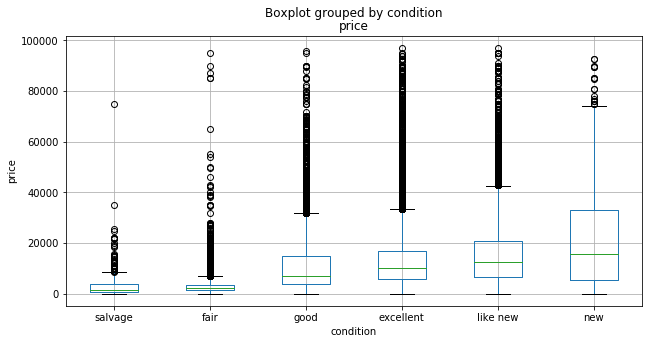

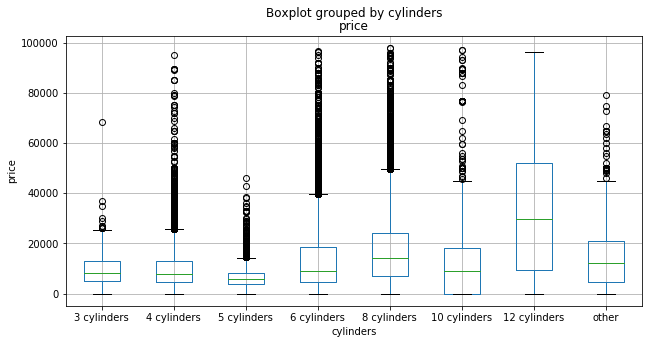

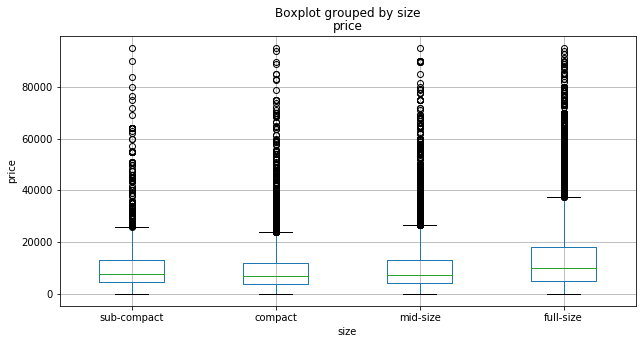

In [23]:
# For each ordinal feature...
for feature in ordinal_features:  
    # Create a box plot for this feature vs. target
    ax = vehicle_data.loc[valid_price_rows, :].boxplot(column='price', by=feature, figsize=(10, 5))
    ax.set_ylabel('price')

For these plots, we conclude the following:
- Condition is a strong indicator for price. We can clearly see the increasing trend when the condition of the car is better.
- Neither 'cylinders' nor 'size' show the expected monotonic relation for an ordinal feature.
 - For example, the average price for 5-cylinder vehicles is less than that of 4-cylinder vehicles, and similarly for 10 vs. 8 cylinders.
 - There is not a significant change in the distribution of prices for sub-compact, compact, or mid-size vehicles.
 
 
 Therefore, we'll only consider '**condition**' as an ordinal feature:

In [24]:
ordinal_features = pd.Index(['condition'])

##### Categorical Features vs. Target

In [25]:
categorical_features = relevant_features.difference(continuous_features.union(ordinal_features), sort=False)

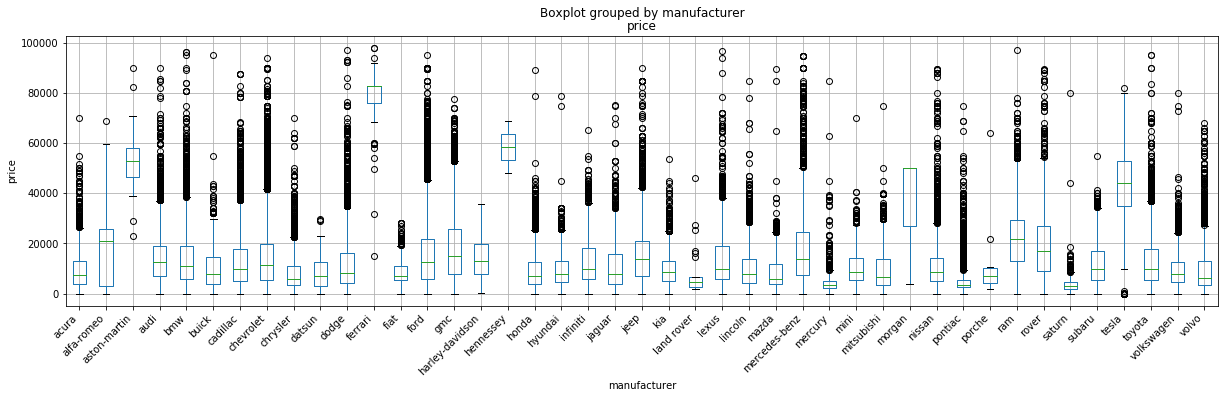

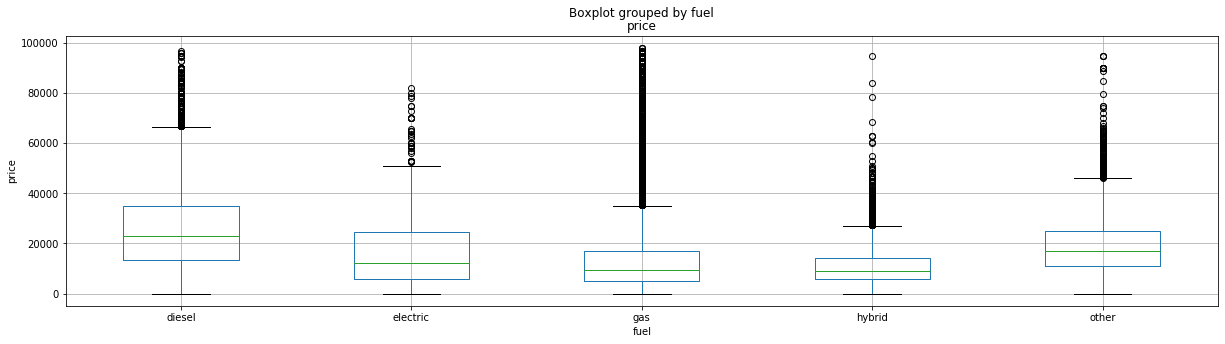

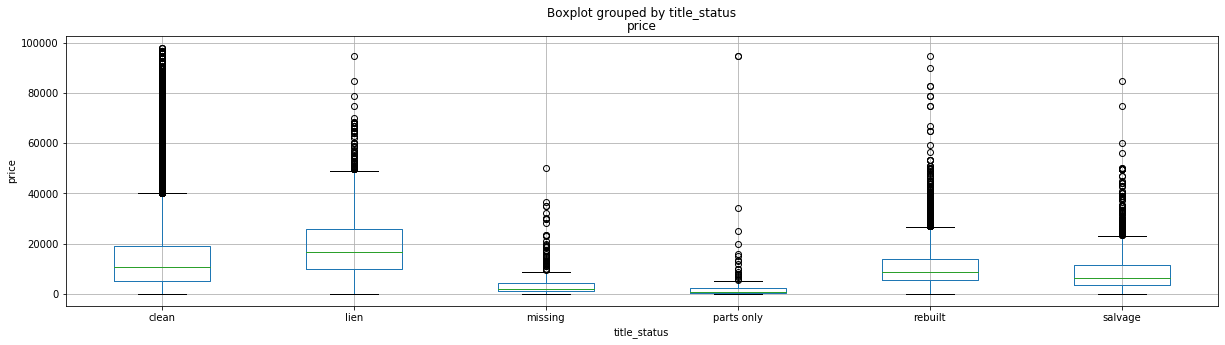

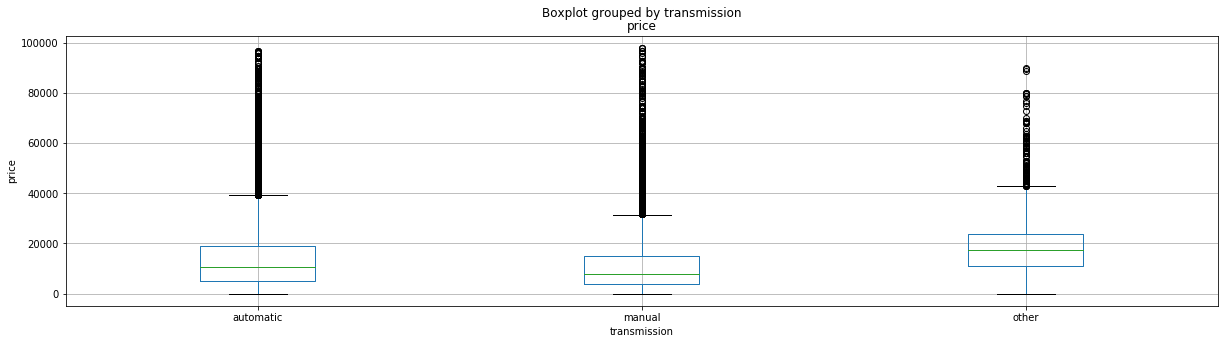

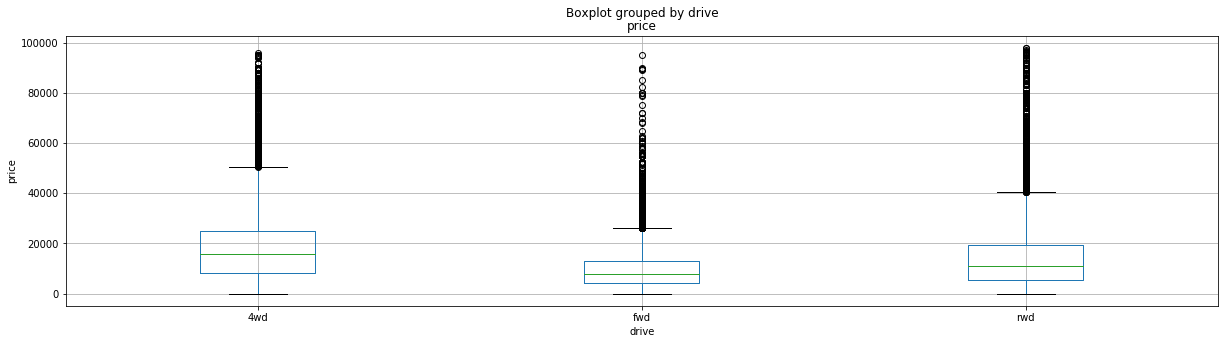

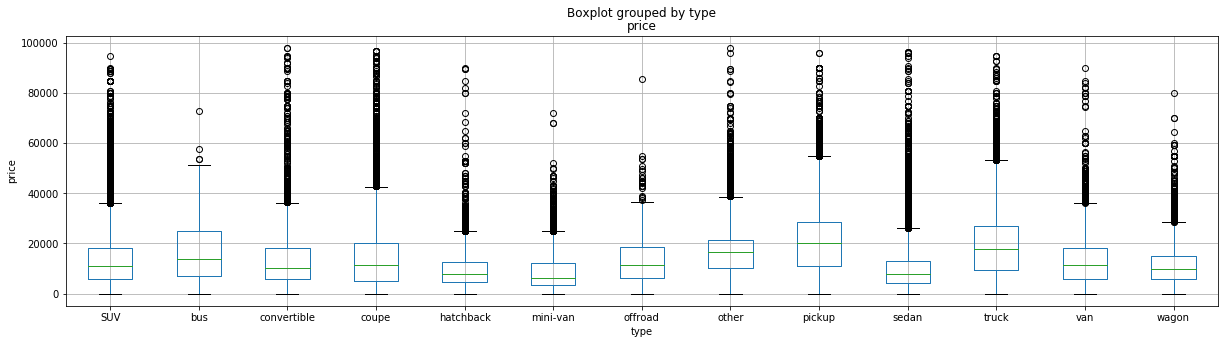

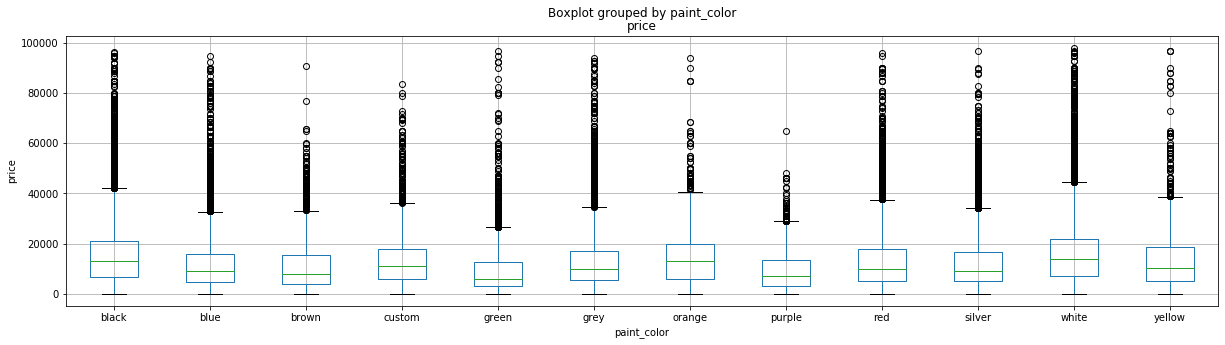

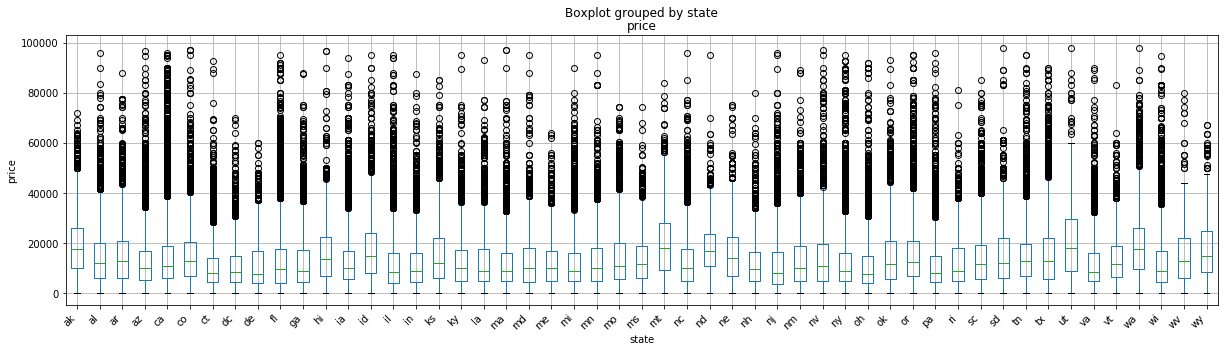

In [26]:
low_card_features = [feat for feat in categorical_features if vehicle_data[feat].nunique() < 52]

for feature in low_card_features:
    # We've already shown boxplots for 'cylinders' and 'size' above, so we don't need to see them again
    if feature in ['cylinders', 'size']: continue
    
    ax = vehicle_data.loc[valid_price_rows, :].boxplot(column='price', by=feature, figsize=(20, 5))
    if len(ax.get_xticklabels()) > 40:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('price')

For these plots, we conclude the following:
- We can see logical trends in the manufacturer feature: cars like Ferrari, Tesla or Aston Martin are more expensive than the rest. We see some strange things as well, like the low price of Land Rovers, but overall the trend could be useful.
- As expected, diesel car are more expensive than the rest on average. The car market runs that way as well.
- Title status "missing" and "parts only" are much lower on average than the rest, as expected. We can see a good trend in this feature with respect to the price.
- As expected, automatic transmission cars are more expensive than manual cars. The "other" category here is not clear, but it's just 4% of the data.
- Following the trend of the market, 4wd cars are more expensive than the others. This feature proves to be useful for classification.
- In vehicle type, we cannot see a very clear trend, but we can find many differences, that can make us go one way or the other with confidence when classifying. This feature will be used for modelling the data.
- On the real car market, paint color is a variable over the price of a car (e.g. red Ferraris are more expensive than other colors). In this data is not as clear as we would like, but the most popular colors (black and white) are higher on average, showing useful trends.
- States don't show a very highly marked trend, but we think that it will give us useful insight when combined with other variables, so we will keep it.

Regarding the remaining categorical features, it is unhelpful to plot them due to the sheer number of categories. For example, 'model' is a really dirty feature which needs heavy and complex cleaning before being a useful source of information. Other high-cardinality categorical variables, like 'region', are possible candidates for Target Encoding.

In [27]:
dirty_features = ['model']

- **Are there any features that should be excluded because they leak the target information?**

The '**id**' feature is unique in this dataset, and therefore could be used to create a perfect mapping of id to price. Obviously this wouldn't generalize to new data.  If id's are assigned sequentially, then 'id' *could* be proxy for the age of the listing.  However, if we assume the overall task is to predict prices for *new* listings, then 'id' would no longer be a distinguishing feature. To avoid leaking any target information to the model, we'll drop 'id'.

We noticed that the '**description**' column could possibly leak some target information if processed correctly, as it occassionally contains pricing information.  
For example, the following are excerpts from entries in the 'description' column, along with the actual target value:  
- "...I am asking $39,500 for this awesome truck..." (price=39,500)

- "...asking $1000 or best offer..." (price=1,000)

- "...asking $23400 or best offer..." (price=23,400)

In [28]:
leaky_features = ['id', 'description']

#### Region analysis
In inspecting the data, we noticed that the '**region**' column might not be specific enough to identify the actual region of the vehicle due to the same city name existing in multiple states.  We see evidence of this when comparing the 'region' column to the '**region_url**' column, which appears to make more distinctions.  The following are a few examples of where 'region' is duplicated:

| **region** | **region_url**                      |
|------------|-------------------------------------|
| albany     | https://albany.craigslist.org       |
| albany     | https://albanyga.craigslist.org     |
| athens     | https://athensga.craigslist.org     |
| athens     | https://athensohio.craigslist.org   |
| charleston | https://charleston.craigslist.org   |
| charleston | https://charlestonwv.craigslist.org |
| columbus   | https://columbus.craigslist.org     |
| columbus   | https://columbusga.craigslist.org   |

As '**region_url**' is a more specific version of the '**region**' feature and more accurately defines the true location of the vehicle, we're going to drop the 'region' feature and use only 'region_url'.

In [29]:
unspecific_features = ['region']

#### Conclusions

From the above analyses, we're going to **drop** the following features for our baseline model:
- 'county' (entirely empty)
- 'url' (irrelevant as is, but we may extract features from it in subsequent steps)
- 'image_url' and 'vin' (irrelevant)
- 'lat' and 'long' (requires feature engineering to be informative)
- 'id' (could leak target information)
- 'description' (could leak target information, but we may extract features from it in subsequent steps)
- 'region' ('region_url' is more accurate)
- 'model' (requires extensive cleanup before it will be useful)

In [30]:
features_to_drop = (empty_features
                    + irrelevant_features
                    + uninformative_features
                    + leaky_features
                    + unspecific_features
                    + dirty_features)
print('Features to drop for Baseline model:', features_to_drop)

Features to drop for Baseline model: ['county', 'url', 'vin', 'image_url', 'lat', 'long', 'id', 'description', 'region', 'model']


---
## Task 2 - Preprocessing and Baseline Model

- **Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model.**

In [31]:
baseline_features = raw_features.columns.difference(features_to_drop, sort=False)
baseline_features

Index(['region_url', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')

#### Prepare Baseline Preprocessing

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
import category_encoders as ce

# Prepare transformation pipelines for different column types
target_encode_pl = make_pipeline(ce.TargetEncoder(), StandardScaler())
median_scale_pl = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
new_cat_ohe_pl = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
impute_good_ord_enc_scale_pl = make_pipeline(SimpleImputer(strategy='constant', fill_value='good'), OrdinalEncoder(categories=[conditions]), StandardScaler())
most_freq_ohe_pl = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

# Contruct our baseline preprocessing transformation
baseline_preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

- **You don't need to validate the model on the whole dataset.**

In [33]:
from sklearn.model_selection import train_test_split

# We'll train and test only on the rows with a valid price
X = raw_features.loc[valid_price_rows,:]
y = raw_target[valid_price_rows]

# Set aside a test set for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)
print('X_train rows:', X_train.shape[0])
print('X_test rows:', X_test.shape[0])

X_train rows: 349115
X_test rows: 116372


#### Baseline model evaluation
In the following block, we'll generate a baseline score for a couple of different linear regressions: OLS and Ridge.

In [34]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [35]:
# Use a ShuffleSplit object to sub-sample the training data for faster cross validataion
shuffle = ShuffleSplit(n_splits=10, train_size=50000, test_size=10000, random_state=25)

In [36]:
# Gather baseline cross validation scores for some linear models
baseline_ols_pipeline = make_pipeline(baseline_preprocessor, LinearRegression())
baseline_ols_score = cross_val_score(baseline_ols_pipeline, X_train, y_train, cv=shuffle).mean()
print(f"Baseline model using OLS regression score: {baseline_ols_score:.6f}")

baseline_ridge_pipeline = make_pipeline(baseline_preprocessor, RidgeCV())
baseline_ridge_score = cross_val_score(baseline_ridge_pipeline, X_train, y_train, cv=shuffle).mean()
print(f"Baseline model using Ridge regression score: {baseline_ridge_score:.6f}")

Baseline model using OLS regression score: 0.417436
Baseline model using Ridge regression score: 0.417438


---
## Task 3 - Feature Engineering

- **Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve the model?**

To test out various different approaches to preprocessing, we'll define a method to consistently compare to our baseline results:

In [37]:
def compare_to_baseline(preprocessing, description=''):
    # Compare the Ridge results to the baseline
    ridge_pipeline = make_pipeline(preprocessing, RidgeCV())
    ridge_score = cross_val_score(ridge_pipeline, X_train, y_train, cv=shuffle).mean()
    print(f"{description+' ' if description else ''}Ridge regression score: {ridge_score:.6f}")
    print(f"(Baseline Ridge regression score: {baseline_ridge_score:.6f})")

### Explore different Pre-Processing for Continuous features

Taking a look at histograms for the continuous features, there appear to be significant outliers present:

/Users/brett/Documents/Python/Virtual Environments/Python 3.7 Virtual Environment/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/brett/Documents/Python/Virtual Environments/Python 3.7 Virtual Environment/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


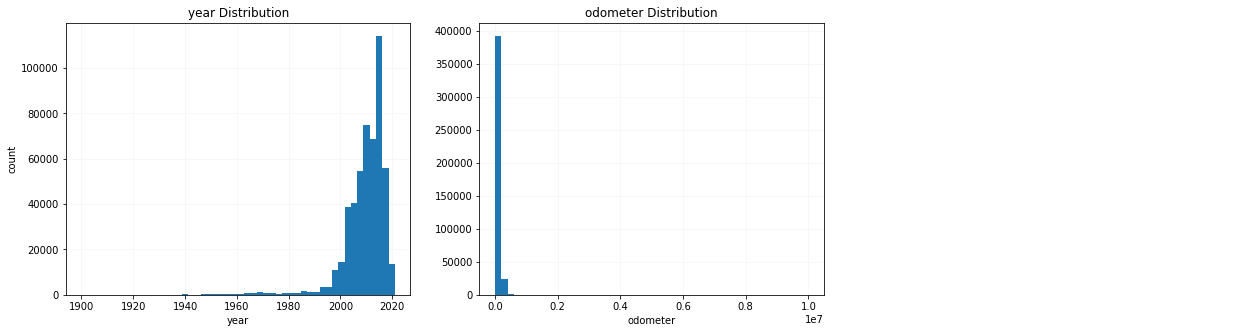

In [38]:
# Figure out an appropriate number of rows and columns
cont_baseline_feats = continuous_features.intersection(baseline_features)
num_plots = len(cont_baseline_feats)
plot_cols = 3
plot_rows = math.ceil(num_plots / plot_cols)
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)

# For each continuous feature...
for i, feature in enumerate(cont_baseline_feats):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
        
    # Create a histogram for this feature
    ax.hist(raw_features[feature], bins=50)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' Distribution')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('count')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_plots
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

It looks like some of this data may be invalid, especially for 'odometer', whose upper range is extremently high.

**Idea**: The first thing we could try is to simply use a **RobustScaler()** instead of the StandardScaler(), which is more robust to outlier values:

In [39]:
# Form a pipline using RobustScaler
from sklearn.preprocessing import RobustScaler
median_robust_scale_pl = make_pipeline(SimpleImputer(strategy='median'), RobustScaler())

# Try preprocessing with RobustScaler
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_robust_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'RobustScaler')

RobustScaler Ridge regression score: 0.417438
(Baseline Ridge regression score: 0.417438)


**Result**: Using RobustScaler didn't appear to have any impact

---

**Idea**: A different approach would be to just **cap extreme values** to a certain percentile prior to scaling.  For example, treat any value greater than the 99th percentile equivalent to the 99th percentile value.

Below is a function that caps the values in a Pandas Series or DataFrame to be between the 1st and 99th percentile of the input data:

In [40]:
def cap_extreme_values(X):
    upper_cap = X.quantile(.99)
    lower_cap = X.quantile(.01)
    ax = 1 if isinstance(X, pd.DataFrame) else None
    X = X.mask(X>upper_cap, upper_cap, axis=ax)
    X = X.mask(X<lower_cap, lower_cap, axis=ax)
    return X

We can visualize the effect of using such a preprocessing technique by re-plotting the capped histograms:

/Users/brett/Documents/Python/Virtual Environments/Python 3.7 Virtual Environment/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/brett/Documents/Python/Virtual Environments/Python 3.7 Virtual Environment/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


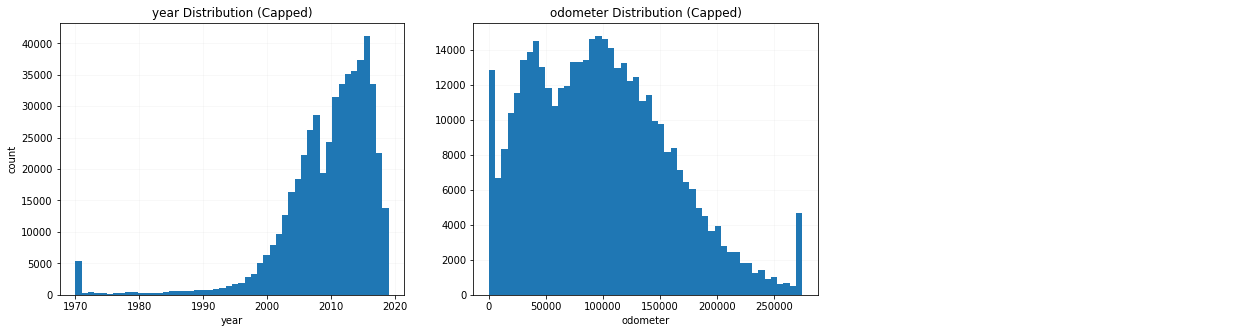

In [41]:
# For each continuous feature...
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows), squeeze=False)
for i, feature in enumerate(cont_baseline_feats):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
        
    # Create a histogram for this feature
    ax.hist(cap_extreme_values(raw_features[feature]), bins=50)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' Distribution (Capped)')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('count')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_plots
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

These distributions look far smoother.  For example, the incredibly high odometer readings have all been capped to around 275,000 miles.  Any values above that will be treated equivalently to this maximum.

Let's see if this capping has any effect on the accuracy of the model:

In [42]:
# Make a Transformer that uses cap_extreme_values()
capper = FunctionTransformer(cap_extreme_values)

# Make new pipelines for incorporating the capping of these continuous values
cap_median_scale_pl = make_pipeline(capper, SimpleImputer(strategy='median'), StandardScaler())

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (cap_median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Capping values')

Capping values Ridge regression score: 0.524436
(Baseline Ridge regression score: 0.417438)


**Result**: Capping the extreme values made a **significant improvement** over the baseline Ridge score

---

**Idea**: An extension of the above idea would be to fully **bin or discretize** the continuous variables, esentially transforming them into categorical variables.

To do this, we'll experiment with the **KBinsDiscretizer** transformer:

In [43]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV

# Make a new pipeline for incorporating the binning of these continuous values
median_bin_pl = make_pipeline(
    SimpleImputer(strategy='median'), KBinsDiscretizer(encode='onehot-dense', strategy='quantile'))

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_bin_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare the Ridge results to the baseline
# We ran the GridSearch with a higher amount of possibilities, but it ran into many warnings,
# we left only the best results for each.
pipeline = make_pipeline(preprocessor, RidgeCV())
param_grid = {'columntransformer__pipeline-2__kbinsdiscretizer__n_bins': range(6, 12, 2)}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=shuffle, refit=False)
grid.fit(X_train, y_train)
score = grid.best_score_
best_n_bins_pl = grid.best_params_['columntransformer__pipeline-2__kbinsdiscretizer__n_bins']

print(("Ridge regression score: %f") % score)
print(("Best number of bins (pipeline): %d") % best_n_bins_pl)

Ridge regression score: 0.613522
Best number of bins (pipeline): 10


**Result**: Discretizing the continuous features made an **even greater improvement** over the baseline Ridge score of 0.417622

---

### Explore different Pre-Processing for Categorical features

**Idea**: **Sub-bin** the categorical variables like 'paint_color' to use fewer distinct values.

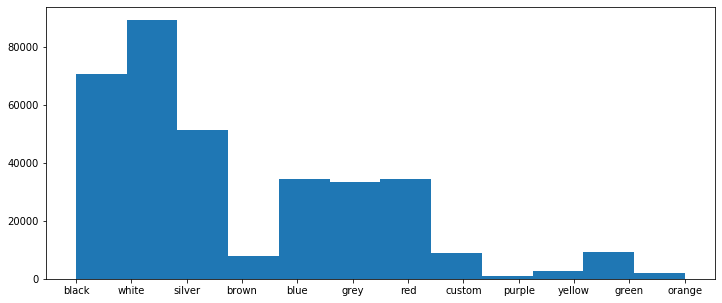

In [44]:
# Show original distribution of paint_color
plt.figure(figsize=(12,5))
plt.hist(raw_features['paint_color'].dropna(), bins=12);

In [45]:
def bin_colors_series(X):
    X = X.mask(X.notna() & X.str.contains('white|black|silver'), 'popular')
    X = X.mask(X.notna() & X.str.contains('blue|red|grey'), 'moderate')
    X = X.mask(X.notna() & X.str.contains('green|custom|brown|yellow|orange|purple'), 'rare')
    return X

def bin_colors(X):
    if isinstance(X, pd.DataFrame):
        return X.apply(bin_colors_series)
    else:
        return bin_colors_series(X)

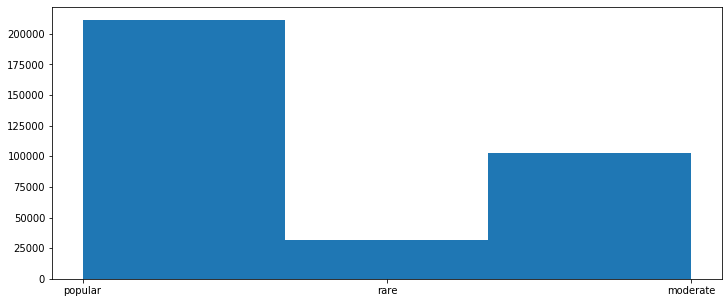

In [46]:
# Show the binned distribution of paint_color
plt.figure(figsize=(12,5))
plt.hist(bin_colors(raw_features['paint_color']).dropna(), bins=3);

Let's see if this sub-binning of paint colors has any impact on our prediction accuracy:

In [47]:
# Make a Transformer that uses bin_colors()
color_binner = FunctionTransformer(bin_colors)

# Make a new pipeline for incorporating the binning of paint_color
bin_color_new_cat_ohe_pl = make_pipeline(color_binner, SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'state']),
    (bin_color_new_cat_ohe_pl, ['paint_color']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Sub-binning Paint Colors')

Sub-binning Paint Colors Ridge regression score: 0.415314
(Baseline Ridge regression score: 0.417438)


**Result**: Sub-binning the paint_color **performed worse** than the baseline Ridge score

---

**Idea**: Try treating the **ordinal features as categorical** to see if that improves the model's performance

From the feature visualizations, we determined that only 'condition' appeared to have a monotonic relationship to the target, and so we treated it as an 'ordinal' feature in our baseline model. But 'condition' has low-cardinality, and could also be treated as a categorical value. How does treating it as categorical affect the model's performance?

In [48]:
# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['condition', 'manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Ordinal -> Categorical features')

Ordinal -> Categorical features Ridge regression score: 0.428374
(Baseline Ridge regression score: 0.417438)


**Result**: Treating 'condition' as a categorical feature **improved the model's performance** compared to the baseline Ridge score

---

### Explore using a Target Transformation

We also tried to use the logarithm of the target, but for the baseline was worse than without it

In [49]:
# from sklearn.compose import TransformedTargetRegressor
# Try converting prices to log
# print("Testing same regressors but with logarithm of price:")
# ridge_log_regressor = TransformedTargetRegressor(RidgeCV(), func=np.log, inverse_func=np.exp)
# baseline_ridge_pipeline = make_pipeline(baseline_preprocessor, ridge_log_regressor)
# baseline_ridge_scores = cross_val_score(baseline_ridge_pipeline, X_train, y_train)
# print(("Baseline model using Ridge regression score: %f") % baseline_ridge_scores.mean())

# ols_log_regressor = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
# baseline_ols_pipeline = make_pipeline(baseline_preprocessor, ols_log_regressor)
# baseline_ols_scores = cross_val_score(baseline_ols_pipeline, X_train, y_train)
# print(("Baseline model using OLS regression score: %f") % baseline_ols_scores.mean())

---
### Explore parsing features from the URL
**Idea**: Use the base of the URL instead of the ``'region_url'`` feature

We found that the base of the ``'url'`` feature was different than the ``'region_url'`` occassionally, although they are identical in the vast majority of rows. We decided to determine which one of these two improves the performance of the model. We tried serveral combinations, leaving only the best one in the notebook: parsing ``'url'``, taking its base and target enconding it.

In [50]:
def get_base_url(X):
    return X['url'].str.extract('//(.+)[.]craigslist[.]org')

In [51]:
# Updated pipeline for url parsing
base_url_target_encode_pl = make_pipeline(FunctionTransformer(get_base_url), ce.TargetEncoder(), StandardScaler())

# Using url instead of region_url and Target Enconding it
preprocessor = make_column_transformer(
    (base_url_target_encode_pl, ['url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Base URL parsing')

Base URL parsing Ridge regression score: 0.417483
(Baseline Ridge regression score: 0.417438)


**Result**: After trying all several combinations, the best improvement is by parsing the url, and using target encoding.  This yields a **very small improvement** over the baseline Ridge score.

---

**Idea**: Adding ``'is_ctd'`` feature, parsed from the URL

We noticed the presence of '/cto/' and '/ctd/' in the craigslist URLs, which after some research, indicates whether this is an 'owner' listing (cto) or a dealer listing (ctd). We suspect that dealer listings may have a higher price on average, and thus may be useful to the model.

First, we will parse out this new feature and use a box plot to see if there's a trend:

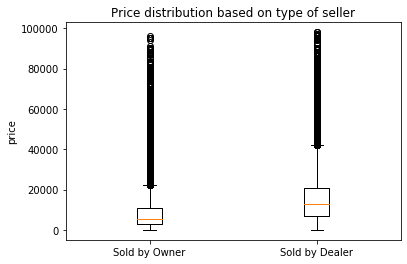

In [52]:
ctd_values = raw_features['url'].str.contains('/ctd/')

is_ctd_targets = y_train[ctd_values]
is_not_ctd_targets = y_train[~ctd_values]

fig, ax = plt.subplots()
ax.set_title('Price distribution based on type of seller')
ax.boxplot([is_not_ctd_targets, is_ctd_targets])
ax.set_xticklabels(['Sold by Owner', 'Sold by Dealer'])
plt.ylabel('price');

Looking at these distributions, we can see that there's a clear trend. The cars sold by dealers are more expensive than the ones sold by owners.

Next we will test our model by including this binary variable to the dataset:

In [53]:
def get_ctd_feature(X):
    return X['url'].str.contains('/ctd/').to_frame()

In [54]:
ctd_parser = FunctionTransformer(get_ctd_feature)

# Parsing CTO/CTD out of URL
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (ctd_parser, ['url']),
    (median_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'CTD/CTO parsing')

CTD/CTO parsing Ridge regression score: 0.424344
(Baseline Ridge regression score: 0.417438)


**Result**: Add this boolean feature to the model shows an **improvement** over the baseline Ridge score.

---

### Explore Cleaning up Manufacturer / Model features

We noticed several issues regarding the 'manufacturer' and 'model' features present in the dataset:
- A significant number of rows had missing 'manufacturer' features, however the correct manufacturer appears in the 'model' column
 - This appears to occur **consistently** for the same manufacturers (e.g. isuzu, suzuki, saab, scion, etc.)
 - When this occurs, the manufacturer does not appear in the 'manufacturer' feature **at all**
- Occassionally, a manufacturer name appears **misspelled** in the 'model' feature, and in these cases the 'manufacturer' feature is missing
 - Similarly, many rows contain **truncated** manufacturer names in the 'mode'l feature (e.g. 'olet' instead of 'chevrolet')
- For rows in which the 'manufacturer' is present, the manufacturer name does **not** appear in the 'model' feature

From these observations, we conclude that some pre-processing of the data has likely taken place in which known manufacturers were somehow parsed out from the 'model' feature.  This would explain both the failure to parse misspelled manufacturers, and the same set of manufacturers consistently failing to appear in the 'manufacturer' feature if the list of known manufacturers was incomplete.

To address this situation, we've **augmented the list of *known* manufacturers**, and will impute missing 'manufacturer' features from the 'model' feature when possible.  In addition, we've included a mapping of frequently misspelled manufacturer names to their correct spelling to improve this imputation process.

The dictionary *manufacturer_map*, constructed below, will map known manufacturers to a list of strings that we'll infer as referring to the manufacturer (e.g. misspellings of their name).

In [55]:
# Gather the list of existing manufacturers from the entire dataset
existing_manufacturers = raw_features['manufacturer'].dropna().unique().tolist()

# Fix existing manufacturer labels for correctness and consistency
existing_manufacturers[existing_manufacturers.index('porche')] = 'porsche'
existing_manufacturers[existing_manufacturers.index('land rover')] = 'land-rover'

"""
Missing manufacturers
This is a list of manufacturers that appear frequently in the 'model' feature,
    but NEVER appear in the 'manufacturer' feature
We're assuming these were not included in the list of known manufacturers when this data was originally processed
"""
missing_manufacturers = [
    'am-general', 'amc', 'austin-healey', 'bentley', 'bluebird', 'cummins', 'freightliner', 'genesis', 'geo', 'hino',
    'international', 'isuzu', 'kawasaki', 'kenworth', 'lamborghini', 'lotus', 'mack', 'maserati', 'mg', 'oldsmobile',
    'packard', 'peterbilt', 'plymouth', 'polaris', 'rolls-royce', 'saab', 'scion', 'smart', 'sterling', 'studebaker',
    'suzuki', 'triumph', 'willys', 'yamaha']

# Combine these lists
all_manufacturers = existing_manufacturers + missing_manufacturers
all_manufacturers.sort()

# Create a dictionary of manufacturer -> strings that refer to them
manufacturer_map = {m:[m] for m in all_manufacturers}   # Every manufacturer will contain at least their correct name

# For manufactuer names with a hyphen, add entry with space instead
for man, strings in manufacturer_map.items():
    if '-' in man:
        strings.append(man.replace('-', ' '))

# Add common misspellings, truncated names, and other aliases
manufacturer_map['bluebird'].append('blue bird')
manufacturer_map['cadillac'].append('caddilac')
manufacturer_map['chevrolet'].extend(['chevorlet', 'cheverolet', 'chevolet', 'chevy', 'olet'])
manufacturer_map['chrysler'].append('chysler')
manufacturer_map['mercedes-benz'].extend(['benz', 'mercedes', 'mercedez'])
manufacturer_map['nissan'].append('n')    # Frequently truncated to 'n'
manufacturer_map['oldsmobile'].append('olds')
manufacturer_map['peterbilt'].append('peterbuilt')
manufacturer_map['hyundai'].extend(['hyndai', 'huyndai', 'hyundia', 'ai'])
manufacturer_map['porsche'].append('porche')
manufacturer_map['subaru'].append('suburu')
manufacturer_map['toyota'].extend(['toyta', 'a'])     # Frequently truncated to 'a'
manufacturer_map['volkswagen'].extend(['volkswagon', 'volkwagen'])

As mentioned earlier, there is a LOT of variation in the 'model' feature, so much so that we couldn't include it in our baseline model without heavy cleanup.  
The first part of cleaning up the 'model' feature will be simple string normalization:

In [56]:
def normalize_model_strings(X):
    # Assume input is a Pandas Series of model strings
    # Return a Series of normalized strings
    
    # Convert everything to lowercase
    X = X.str.lower()
    
    # Replace any character that is not a letter, number, dash or space with a space
    X = X.str.replace('[^-a-z0-9 ]', ' ')
    
    # Collapse runs of multiple spaces into a single space
    X = X.str.replace(' +', ' ')
    
    # Strip any whitespace from the ends of the strings
    X = X.str.strip()
    
    # Return the normalized strings
    return X

The following method cleans up both the 'manufacturer' and 'model' features for this dataset.  It does this by:
- Correcting errors and inconsistencies in the original parsing of manufacturer names
- Imputing missing 'manufacturer' values from the 'model' values, using the expanded list of known manufacturers and their frequent misspellings
- Restricting the 'model' values to only their **first word** (after normalization and manufacturer parsing), to construct a reasonable set of distinct values
 - We also append the parsed out manufacturer name (if available) to distinguish between common models / garbage data

In [57]:
def clean_manufacturer_model(X):
    """
    Assume X is a Pandas DataFrame with at least 'manufacturer' and 'model' columns
    Return a DataFrame with cleaned up and imputed values in these same columns
    """
    
    # We'll operate on a copy of the input
    X = X.copy()
    
    # Fix existing manufacturer parsing
    X['manufacturer'].replace(['porche', 'land rover'], ['porsche', 'land-rover'], inplace=True)
    
    # Normalize model strings
    X['model'] = normalize_model_strings(X['model'])
    
    # Impute missing manufacturers from the values in the 'model' column:
    # Get a selection of rows with missing manufacturers
    missing_manu = X.loc[X['manufacturer'].isna(), :].copy()
    
    # For each string in our manufacturer -> strings mapping...
    for manufacturer, strings in manufacturer_map.items():
        for string in strings:
            """
            Try to find the string at the beginning of the 'model' values, skipping over any non-alpha characters
            The manufacturer string must be separated from the rest model by some non-alpha character
            If found, extract the portion of the 'model' string after the manufacturer name
            """
            manu_substring = missing_manu['model'].str.extract('^[^a-z]*'+string+'([^a-z].*)', expand=False)
            
            # For all rows in which the find was successful, fill in the current value in the 'manufacturer' column
            missing_manu.loc[manu_substring.notna(), 'manufacturer'] = manufacturer
            
            # Also strip the manufacturer name (and any leading characters) from the 'model' values,
            #     since it has been successfully parsed out
            missing_manu['model'].mask(manu_substring.notna(), manu_substring, inplace=True)

    """
    Repeat the process, getting a little more agressive in our search
    Now, we won't require a non-alpha character to separate the manufacturer from the model.
    This should allow us to correctly parse out the manufacturer from model strings like 'FordF150'
    We'll only impute manufacturers that are still missing from the previous step, 
        and we won't do this for really short strings
    """
    for manufacturer, strings in manufacturer_map.items():
        for string in strings:
            # Don't perform the agressive search if the string is too short (not precise enough)
            if len(string) > 2:
                # Same as above, but not requiring a non-alpha character between manufacturer and model
                manu_substring = missing_manu['model'].str.extract('^[^a-z]*'+string+'(.*)', expand=False)
                # Only update manufacturers that are still empty (i.e. don't overwrite the previous step's values)
                missing_manu.loc[
                    missing_manu['manufacturer'].isna() & manu_substring.notna(), 'manufacturer'] = manufacturer
                # Updating the model value is the same
                missing_manu['model'].mask(manu_substring.notna(), manu_substring, inplace=True)

    # Have our input (copy) take the updated values we just found
    X.update(missing_manu)
    
    # Discretize model strings by only considering the first word
    # Remove any whitespace potentially left over from manufacturer parsing
    X['model'] = X['model'].str.strip()
    # Remove any hyphens to improve consistency of model designations (e.g. Honda CR-V vs CRV)
    X['model'] = X['model'].str.replace('-', '', regex=False)
    # Extract just the first word of the model string
    X['model'] = X['model'].str.extract('^([^ ]+)', expand=False)
    
    # Append the manufacturer name to model string, if available
    manu_space = X['manufacturer']+' '
    X['model'] = manu_space.mask(manu_space.isna(), '').str.cat(X['model'])

    # Return the cleaned up dataframe
    return X

Now we can try a model using cleaned up versions of the 'manufacturer' and 'model' features:

In [58]:
# Construct a transformer that calls the clean_manufacturer_model() method
# Note that this must be called with BOTH the manufacturer and model columns
man_model_cleaner = FunctionTransformer(clean_manufacturer_model)

"""
We need BOTH the 'manufacturer' and 'model' features to properly clean up / impute either of them.
However, after their clean up, we'll want to continue to process the columns differently.

We'll use two separate pipelines to accomplish this, both of which extract only
    the column they need for further pre-processing.
"""
manufacturer_pl = make_pipeline(
    man_model_cleaner, FunctionTransformer(
        lambda X: X[['manufacturer']]), SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
model_pl = make_pipeline(
    man_model_cleaner, FunctionTransformer(lambda X: X[['model']]), ce.TargetEncoder(), StandardScaler())

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year', 'odometer']),
    (manufacturer_pl, ['manufacturer', 'model']),   # Must pass BOTH columns, but only encodes 'manufacturer'
    (model_pl, ['manufacturer', 'model']),          # Must pass BOTH columns, but only encodes 'model'
    (new_cat_ohe_pl, ['cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Cleaned Manufacturer/Model')

Cleaned Manufacturer/Model Ridge regression score: 0.500348
(Baseline Ridge regression score: 0.417438)


**Result**: Cleaning up and imputing the manufacturer and model features made a **significant improvement** over the baseline Ridge score

---

### Explore adding Feature Interactions

We're going to explore adding feature interactions between the 'year' and 'odometer' features.  Intuitively this sounds promising, since there is a tradeoff between the age and mileage of a vehicle which regard to its value.

**Idea**: Add the **polynomial interactions** between 'year' and 'odometer' as new features.

In [59]:
from sklearn.preprocessing import PolynomialFeatures

# Make a new pipeline for including the interactions between two continuous features
median_poly_scale_pl = make_pipeline(SimpleImputer(strategy='median'), PolynomialFeatures(), StandardScaler())

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_poly_scale_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Year/Odometer Interactions')

Year/Odometer Interactions Ridge regression score: 0.509643
(Baseline Ridge regression score: 0.417438)


**Result**: This resulted in a **significant improvement** over the baseline Ridge score

---

**Idea**: Previously, we found that binning the 'year' and 'odometer' features improved our results.  Now we'll try adding the **interactions between the binned results**, combining two ideas that both improved the score individually.

In [60]:
from sklearn.feature_selection import VarianceThreshold

# Make a new pipeline for including the interactions between two binned features
# We'll use the best n_bins obtained from previous GridSearchCV
# Include a VarianceThreshold object to remove the constant (0) features created
# via interactions of one-hot encoded columns.
median_bin_poly_pl = make_pipeline(SimpleImputer(strategy='median'), KBinsDiscretizer(
        n_bins=best_n_bins_pl, encode='onehot-dense'), PolynomialFeatures(), VarianceThreshold())

# Try this updated preprocessing
preprocessor = make_column_transformer(
    (target_encode_pl, ['region_url']),
    (median_bin_poly_pl, ['year', 'odometer']),
    (new_cat_ohe_pl, ['manufacturer', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (impute_good_ord_enc_scale_pl, ['condition']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(preprocessor, 'Year/Odometer Binned Interactions')

Year/Odometer Binned Interactions Ridge regression score: 0.618909
(Baseline Ridge regression score: 0.417438)


**Result**: Using both binning and feature interactions between the 'year' and 'odometer' features performs better than either of them individually, and yields a **big improvement** over the baseline Ridge score.

---

### Task 3 Conclusions

We'll combine all of our ideas that performed better than the baseline score into a single preprocessing pipeline:

In [61]:
# Try the full preprocessings combined
BEST_PREPROCESSOR = make_column_transformer(
    (base_url_target_encode_pl, ['url']),
    (ctd_parser, ['url']),
    (median_bin_poly_pl, ['year', 'odometer']),
    (manufacturer_pl, ['manufacturer', 'model']),
    (model_pl, ['manufacturer', 'model']),
    (new_cat_ohe_pl, ['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

# Compare this preprocessing the baseline
compare_to_baseline(BEST_PREPROCESSOR, 'All beneficial improvements at once')

All beneficial improvements at once Ridge regression score: 0.666816
(Baseline Ridge regression score: 0.417438)


**Conclusion**: By combining all the ideas that improved the score, we get an **almost 60% improvement** over the baseline R^2 score.

---

## Task 4 - Any Model

- **Use any regression model we discussed to improve your result**.

For this task, we will try out 3 different models: **k-Nearest Neighbors, Random Forest, and Gradient Boosting**

### K-Nearest Neighbors

In [62]:
from sklearn.neighbors import KNeighborsRegressor

# Since KNN requires scaled data and can't handle missing values,
# we'll use the same preprocessing as we did for the linear models.

# Get a baseline score for k-Nearest Neighbors
knn_pipe = make_pipeline(BEST_PREPROCESSOR, KNeighborsRegressor(n_jobs=n_jobs))
knn_baseline_score = cross_val_score(knn_pipe, X_train, y_train, cv=shuffle).mean()
print(f"Baseline score for kNN: {knn_baseline_score:.6f}")

Baseline score for kNN: 0.707095


Now we'll tune the number of neighbors using a grid search:  
**Note**: After running a grid search over the number of neighbors at several ranges, we reduced the search to a smaller range to make the Notebook run a bit faster. 

In [63]:
param_grid = {'kneighborsregressor__n_neighbors': range(5, 15, 2)}
knn_grid = GridSearchCV(knn_pipe, param_grid=param_grid, cv=shuffle, refit=False)
knn_grid.fit(X_train, y_train)

print(f"Optimized score for kNN: {knn_grid.best_score_:.6f}")
knn_tuned_n_neighbors = knn_grid.best_params_['kneighborsregressor__n_neighbors']
print(f"Best n_neighbors: {knn_tuned_n_neighbors}")

Optimized score for kNN: 0.711528
Best n_neighbors: 11


The score of this model, including the hyperparameter tuning, is a **moderate improvement** over our linear regressor.

Let's plot the mean cross validation score vs. the n_neighbors parameter to see the results of the tuning:

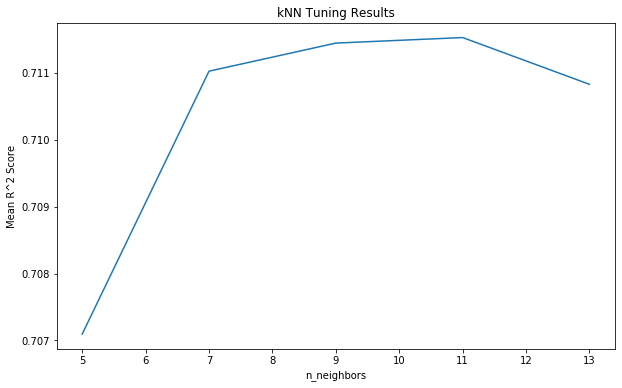

In [64]:
cv_results = pd.DataFrame(knn_grid.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_kneighborsregressor__n_neighbors'], cv_results['mean_test_score'])
plt.title('kNN Tuning Results')
plt.xlabel('n_neighbors')
plt.ylabel('Mean R^2 Score');

### Random Forest Regressor

In [65]:
# Since Random Forests (and trees in general) are not affected by scaling of the data,
# we can remove the scaling steps from the best preprocessing we found in Task 3
base_url_target_encode_no_scale_pl = make_pipeline(FunctionTransformer(get_base_url), ce.TargetEncoder())
model_no_scale_pl = make_pipeline(man_model_cleaner, FunctionTransformer(lambda X: X[['model']]), ce.TargetEncoder())

BEST_PREPROCESSOR_NO_SCALING = make_column_transformer(
    (base_url_target_encode_no_scale_pl, ['url']),
    (ctd_parser, ['url']),
    (median_bin_poly_pl, ['year', 'odometer']),
    (manufacturer_pl, ['manufacturer', 'model']),
    (model_no_scale_pl, ['manufacturer', 'model']),
    (new_cat_ohe_pl, ['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

In [66]:
from sklearn.ensemble import RandomForestRegressor

# Get a baseline score for a Random Forest Regressor
rf = RandomForestRegressor(random_state=25, n_jobs=n_jobs)
rf_pipe = make_pipeline(BEST_PREPROCESSOR_NO_SCALING, rf)
rf_baseline_score = cross_val_score(rf_pipe, X_train, y_train, cv=shuffle).mean()
print(f"Baseline score for Random Forest: {rf_baseline_score:.6f}")

Baseline score for Random Forest: 0.771385


Now we'll try tuning the **max_features** parameter:

In [67]:
param_grid = {'randomforestregressor__max_features': np.linspace(0.1, 1.0, 10)}
rf_grid = GridSearchCV(rf_pipe, param_grid, cv=shuffle, refit=False)
rf_grid.fit(X_train, y_train)

print(f"Optimized score for Random Forest: {rf_grid.best_score_:.6f}")
rf_tuned_max_features = rf_grid.best_params_['randomforestregressor__max_features']
print(f"Best max_features: {rf_tuned_max_features}")

Optimized score for Random Forest: 0.781206
Best max_features: 0.2


This best score is **much better** than the results we achieved using the linear models in Tasks 2 and 3 using the same cross validation.

Let's plot the mean cross validation score vs. the max_features parameter to see the results of the tuning:

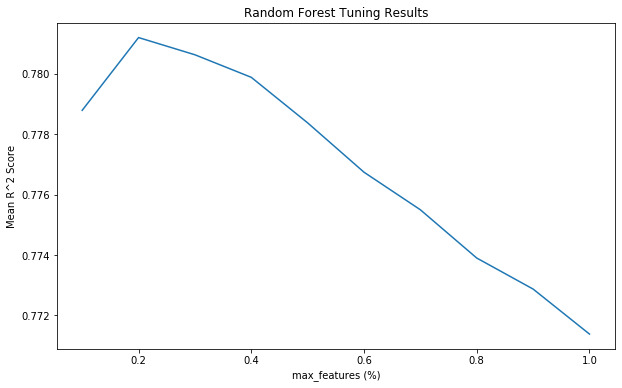

In [68]:
cv_results = pd.DataFrame(rf_grid.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_randomforestregressor__max_features'], cv_results['mean_test_score'])
plt.title('Random Forest Tuning Results')
plt.xlabel('max_features (%)')
plt.ylabel('Mean R^2 Score');

Using the best 'max_features' parameter we found in our grid search, we can get an estimate on how well the RandomForestRegressor model will perform when trained on the entire training set by looking at the '**Out-of-Bag**' score:

In [69]:
best_max_features = rf_grid.best_params_['randomforestregressor__max_features']
rf = RandomForestRegressor(n_estimators=100, max_features=best_max_features, oob_score=True, n_jobs=n_jobs, random_state=25, warm_start=True)
rf_pipe = make_pipeline(BEST_PREPROCESSOR_NO_SCALING, rf)
rf_pipe.fit(X_train, y_train)
print(f"Tuned Random Forest OOB score: {rf_pipe.named_steps['randomforestregressor'].oob_score_:.6f}")

Tuned Random Forest OOB score: 0.868018


While we can't compare the R^2 score of 0.868 to the sampled cross validation scores (since it is trained on much more data), this should give us a rough estimate of how well the Random Forest will perform on the test data (when using all of the training data).

Finally, we want to make sure the **number of trees** we're using is sufficient (knowing that more trees is always better).  
We'll try **doubling the number of trees** to 200 and see what sort of improvement that has on the OOB score.  
Since we used '**warm_start**', this should only have to add 100 trees to the existing model:

In [70]:
rf_pipe.set_params(randomforestregressor__n_estimators=200)
rf_pipe.fit(X_train, y_train)
print(f"Tuned Random Forest OOB score (w/200 trees): {rf_pipe.named_steps['randomforestregressor'].oob_score_:.6f}")

Tuned Random Forest OOB score (w/200 trees): 0.869988


Doubling the number of trees only had a **minor impact on the OOB score**, from which we can conclude that around 100-200 trees are sufficient to get the best results from Random Forest on this data set.

### Histogram Gradient Boosting
**Note**: when trying to make this regressor work, we found that hyperparameter tuning is **very** slow using GridSearch. We tried many different combinations, but we ended up with a tradeoff between speed and performance in order to be able to keep working and not waiting hours to this to be optimized.

The HistGradientBoostingRegressor class **handles missing values** natively. Therefore, we'll **remove imputation** (when possible) from our preprocessing pipeline. (Some preprocessing like binning and one-hot encoding still require imputation.)

And since the model is tree-based, we also don't need to perform **scaling** in our preprocessing either.

In [71]:
base_url_target_encode_leave_missing_no_scale_pl = make_pipeline(FunctionTransformer(get_base_url), ce.TargetEncoder(handle_missing='return_nan'))
model_leave_missing_no_scale_pl = make_pipeline(man_model_cleaner, FunctionTransformer(lambda X: X[['model']]), ce.TargetEncoder(handle_missing='return_nan'))

BEST_PREPROCESSOR_LEAVE_MISSING_NO_SCALING = make_column_transformer(
    (base_url_target_encode_leave_missing_no_scale_pl, ['url']),
    (ctd_parser, ['url']),
    (median_bin_poly_pl, ['year', 'odometer']),
    (manufacturer_pl, ['manufacturer', 'model']),
    (model_leave_missing_no_scale_pl, ['manufacturer', 'model']),
    (new_cat_ohe_pl, ['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color', 'state']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']))

In [72]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Get a baseline score for a Histogram Gradient Boosting Regressor
hgb_pipe = make_pipeline(BEST_PREPROCESSOR_LEAVE_MISSING_NO_SCALING, HistGradientBoostingRegressor(random_state=25))
hgb_baseline_score = cross_val_score(hgb_pipe, X_train, y_train, cv=shuffle).mean()
print(f"Baseline score for HistGradientBoosting: {hgb_baseline_score:.6f}")

Baseline score for HistGradientBoosting: 0.750230


Now we'll try tuning the **learning_rate** parameter:

In [73]:
# Params optimization
# param_grid = {'histgradientboostingregressor__learning_rate': np.logspace(-1, 0, 5)}  # Initial coarse grid search
param_grid = {'histgradientboostingregressor__learning_rate': np.linspace(0.1,0.3,10)}  # Fine-tuning grid search
hgb_pipe = make_pipeline(BEST_PREPROCESSOR_LEAVE_MISSING_NO_SCALING, HistGradientBoostingRegressor(max_leaf_nodes=50, max_iter=500, random_state=25))
hgb_grid = GridSearchCV(hgb_pipe, param_grid, cv=shuffle, refit=False)
hgb_grid.fit(X_train, y_train)

print(f"Optimized score for HistGradientBoosting: {hgb_grid.best_score_:.6f}")
hgb_tuned_learning_rate = hgb_grid.best_params_['histgradientboostingregressor__learning_rate']
print(f"Best learning rate: {hgb_tuned_learning_rate}")

Optimized score for HistGradientBoosting: 0.788518
Best learning rate: 0.16666666666666666


This best score is **much better** than the results we achieved using the linear models in Tasks 2 and 3 using the same cross validation, and quite close to the best score achieved by Random Forest above.

One of the parameters we tried to optimize was ``max_leaf_nodes`` and it continued to improve when we increased it. We moved it up to 200 and it kept improving (about 0.788), but the computation time was too large. Also we tried increasing ``max_iter`` up to 300. Grid searching using ``max_leaf_nodes = 100`` and ``max_iter = 300`` our score went up to 0.78, but the running time was over an hour only for the grid search itself.

Let's plot the mean cross validation score vs. the max_features parameter to see the results of the tuning:

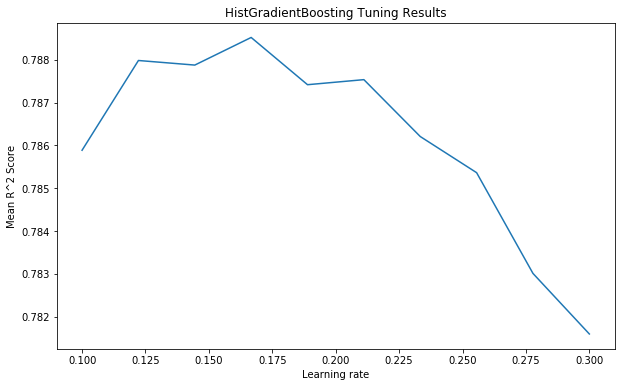

In [74]:
cv_results = pd.DataFrame(hgb_grid.cv_results_)
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_histgradientboostingregressor__learning_rate'], cv_results['mean_test_score'])
plt.title('HistGradientBoosting Tuning Results')
plt.xlabel('Learning rate')
plt.ylabel('Mean R^2 Score');

### Conclusions

- All of these models performed better than the linear models initially used, even before tuning their hyperparameters.
- Among the three, both **Random Forest** and **Histogram Gradient Boosting** performed significantly better than k-Nearest Neighbors.
- Random Forest performed very well prior to any tuning, and the increase in performance from tuning was modest.
- Histogram Gradient Boosting performed slightly worse than Random Forest during the baseline test, but achieved a slightly higher CV score after careful tuning.

The cross validation splits used to compare these models heavily sub-sample the training data in order to decrease the training times. To decide which of these two models is the best, it would help to compare their cross validation scores on a **larger sample of training data** via a traditional k-Fold CV:

In [75]:
tuned_rf_pipe = make_pipeline(BEST_PREPROCESSOR_NO_SCALING,
                              RandomForestRegressor(max_features=rf_tuned_max_features, random_state=25, n_jobs=n_jobs))
tuned_rf_score = cross_val_score(tuned_rf_pipe, X_train, y_train, cv=5).mean()
print(f"Tuned Random Forest Score: {tuned_rf_score:.6f}")

Tuned Random Forest Score: 0.858657


In [76]:
tuned_hgb_pipe = make_pipeline(BEST_PREPROCESSOR_LEAVE_MISSING_NO_SCALING,
                               HistGradientBoostingRegressor(learning_rate=hgb_tuned_learning_rate, max_leaf_nodes=50, max_iter=500, random_state=25))
tuned_hgb_score = cross_val_score(tuned_hgb_pipe, X_train, y_train, cv=5).mean()
print(f"Tuned HGB Score: {tuned_hgb_score:.6f}")

Tuned HGB Score: 0.836067


As expected, both of these scores are **significantly higher** than those achieved when the models were trained on less data.

Based on these final results, we're going to predict that **Random Forest** will generalize the best on new data.

Finally, we can evaluate our best model on the **test data**, after re-training it using the entire training dataset:

In [77]:
BEST_MODEL = tuned_rf_pipe
BEST_MODEL.fit(X_train, y_train)
best_score = BEST_MODEL.score(X_test, y_test)
print(f"Best Model Test Score: {best_score:.6f}")

Best Model Test Score: 0.868862


---

## Task 5 - Feature Selections

- **Identify features that are important for your best model.**

We'll use the **Permutation Importance** on the test data set to measure feature importances:

In [78]:
from sklearn.inspection import permutation_importance

perm_results = permutation_importance(BEST_MODEL, X_test, y_test, random_state=25)

We'll visualize these feature importances for easy reference:

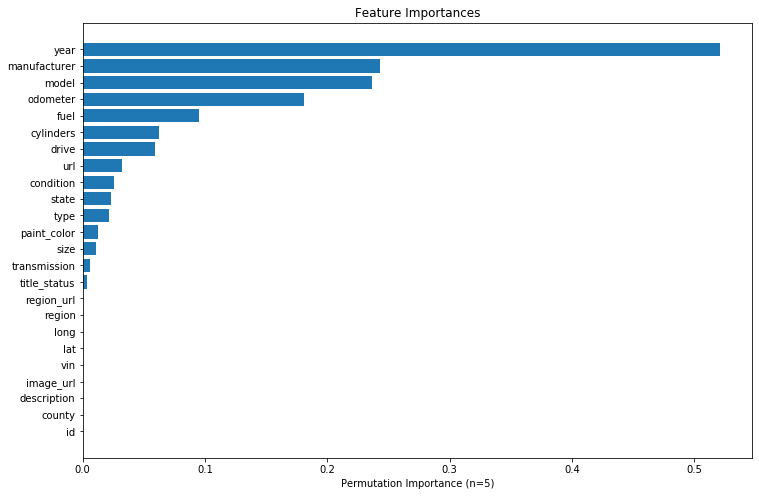

In [79]:
features = X_test.columns.tolist()
n_features = len(features)

importances = perm_results['importances_mean']
sort_idx = np.argsort(importances)

fig,ax = plt.subplots(figsize=(12,8))
ax.barh(range(n_features), importances[sort_idx], align='center')
ax.set_yticks(range(n_features))
ax.set_yticklabels(np.array(features)[sort_idx])
ax.set_xlabel('Permutation Importance (n=5)')
ax.set_title('Feature Importances');

- **Which features are most influential?**

These results suggest that the **year, make, model, and mileage** of a vehicle are the most important features to our pricing model, and this agrees with our intuition about how cars are typically valued.

As expected, the features not included in our preprocessing pipeline (e.g. vin, image_url, county, etc.) have a permutation importance of 0.

- **Which features could be removed without a decrease in performance?**

- **Does removing irrelevant features make your model better?**

The answer to this question depends heavily on one's iterpretation of 'better'.  Removing the irrelevant features may not result in an increased scoring measurement, but it does provide other tangible benefits:
- The training (and testing) time for the model will decrease when using fewer features
- The size of the model (and possibly the dataset) will be smaller, requiring less memory/disk space
- The model is more interpretable with a fewer number of influential features to explain

In [226]:
unused_features = ['id', 'long', 'county', 'region', 'region_url', 'description', 'image_url', 'vin', 'lat']

# Use a ShuffleSplit object to sub-sample the training data for faster cross validataion
fs_shuffle = ShuffleSplit(n_splits=10, train_size=50000, test_size=10000, random_state=25)
tuned_rf_pipe = make_pipeline(BEST_PREPROCESSOR_NO_SCALING,
                              RandomForestRegressor(max_features=0.3, random_state=25, n_jobs=n_jobs))
tuned_rf_score = cross_val_score(tuned_rf_pipe, X_train, y_train, cv=fs_shuffle).mean()
print(f"Tuned Random Forest Score: {tuned_rf_score:.6f}")

Tuned Random Forest Score: 0.780636


In [227]:
from copy import deepcopy
import time
sorted_importance = importances[sort_idx]
current_preprocessor = deepcopy(BEST_PREPROCESSOR_NO_SCALING)
mean_scores = []
last_removed_feature = []
processing_times = []
for i, feature in enumerate(features_by_importance):
    features_for_iteration = []
    if i > 16:
        break
    if feature in unused_features:
        continue
    last_removed_feature.append(feature)

    for transformer in current_preprocessor.transformers:
        if feature in transformer[2]:
            transformer[2].remove(feature)
        features_for_iteration += transformer[2]
    current_rf_pipe = make_pipeline(current_preprocessor,
                              RandomForestRegressor(max_features=0.3, random_state=25, n_jobs=n_jobs))
    start_time = time.time()
    current_rf_score = cross_val_score(current_rf_pipe, X_train, y_train, cv=fs_shuffle).mean()
    mean_scores.append(current_rf_score)
    processing_times.append(time.time() - start_time)

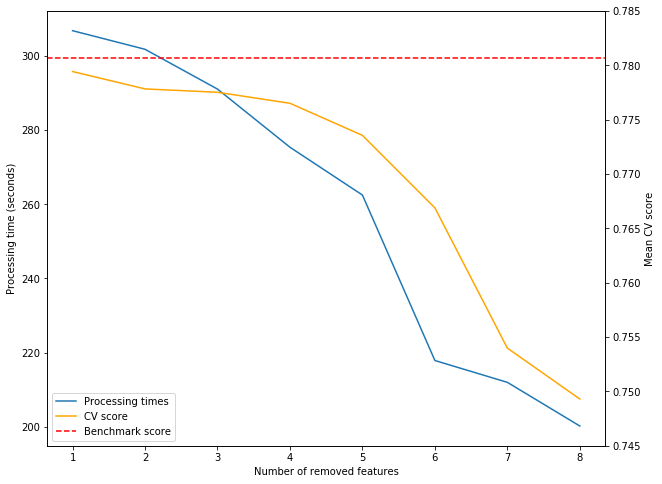

In [255]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(processing_times, label='Processing times')
ax.set_xticklabels(range(len(last_removed_feature) + 1))
ax.set_xlabel('Number of removed features')
ax.set_ylabel('Processing time (seconds)')
ax.set_title('Impact in removing features')
ax2 = ax.twinx()
ax2.plot(mean_scores, color='orange', label='CV score')
ax2.set_xticklabels(range(len(last_removed_feature) + 1))
ax2.set_ylabel('Mean CV score')
ax2.axhline(y=tuned_rf_score, color='r', linestyle='--', label='Benchmark score')
ax2.set_ylim(0.745, 0.785)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

Conclusions:
- Every removal takes an amount of score out of the baseline, first with less impact than after, as we can see in our plot
- Processing times also are reduced, showing that there's a silver lining in removing features
- In the end, we consider that removing **up to 3 features** could be acceptable, without falling into major losses in score.